# Здравствуйте, Артём
### Немного кода и примеров того, что мы сделали (только в python)

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [6]:
# Bathy colormap (https://matplotlib.org/stable/tutorials/colors/colormapnorms.html)

colors_above500 = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_below500 = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_above500, colors_below500))
terrain_map = colors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)

# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=100, vmax=5000)

# pcm = ax.pcolormesh(longitude, latitude, topo, rasterized=True, norm=divnorm,
#                     cmap=terrain_map, shading='auto')

## 1. Координатная сетка

In [5]:
# Исходная сетка ORCA_R025
R025 = xr.open_dataset('ORCA_R25_coordinates.nc')
R025

<xarray.Dataset>
Dimensions:  (y: 1021, x: 1442, time: 1)
Coordinates:
  * time     (time) object 0000-01-01 00:00:00
Dimensions without coordinates: y, x
Data variables: (12/18)
    nav_lon  (y, x) float32 ...
    nav_lat  (y, x) float32 ...
    glamt    (time, y, x) float64 ...
    glamu    (time, y, x) float64 ...
    glamv    (time, y, x) float64 ...
    glamf    (time, y, x) float64 ...
    ...       ...
    e1v      (time, y, x) float64 ...
    e1f      (time, y, x) float64 ...
    e2t      (time, y, x) float64 ...
    e2u      (time, y, x) float64 ...
    e2v      (time, y, x) float64 ...
    e2f      (time, y, x) float64 ...
Attributes: (12/17)
    Conventions:                         GDT 1.2
    file_name:                           meshmask_000.nc
    TimeStamp:                           2003-AUG-05 06:29:29 GMT+0000
    PE_number:                           0
    PE_total_number:                     12
    DOMAIN_global_size:                  [1442 1021   46    1]
    ...                                  ...
    history:                             Fri Aug 28 14:21:58 2009: ncks -a te...
    nco_openmp_thread_number:            1
    Original_coords_file:                /data/local/hadic/NEMO/ORCA025_LIM/s...
    Modified_coords_file:                /data/local/hadic/NEMO/ORCA025_LIM/s...
    Program:                             coords_postproc.f90
    Executed:                            12:40:32+01:00:00 GMT 28-08-2009

### Создание родительского домена

In [7]:
shift = 168  # Euresian landpoints
delta = 65  # American landpoints
ashift = 721  # Middle index in x-direction

test1 = R025.drop_isel(y=list(range(824)), x=list(range(shift))+list(range(ashift-delta,len(R025.x))))
test1 = test1.reindex(y=test1.y, x=test1.x)
test1 = test1.drop_isel(y=[-1,-2,-3])  # North folding deletion
test2 = R025.drop_isel(y=list(range(797)), x=list(range(-1,-shift,-1))+list(range(0,ashift+delta+1)))
test2 = test2.reindex(x=test2.x[::-1])
test2 = test2.reindex(x=test2.x[::-1], y=np.arange(test1.y.max()+1+test2.y.max(), test1.y.max(), -1))

# Соединение и реиндексация
itogo = xr.concat([test1,test2],'y')
itogo = itogo.sortby(["y", "x"])

itogo

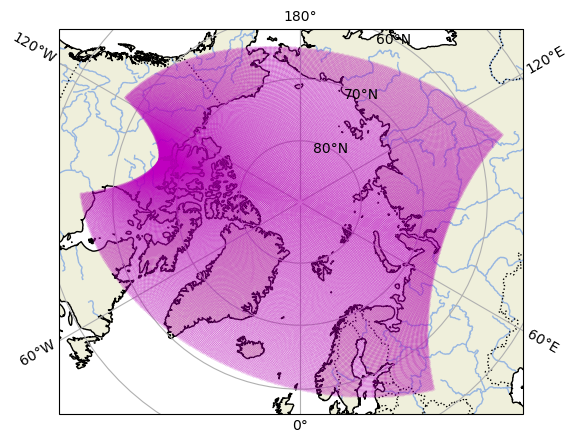

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.scatter(itogo.nav_lon[:,:], itogo.nav_lat[:,:], transform=ccrs.PlateCarree(), s=0.003, c='m', zorder=2)
# this = ax.pcolormesh(itogo.nav_lon, itogo.nav_lat, itogo.e2t[0,:,:], transform=ccrs.PlateCarree(), shading='gouraud')
# this = ax.pcolormesh(itogo.nav_lon[-6:, :], itogo.nav_lat[-6:, :], itogo.nav_lon[-6:, :],
#                      transform=ccrs.PlateCarree(), shading='gouraud')
# ax.set_extent([180, -180, 90, 55], crs=ccrs.PlateCarree())  # All domain
# ax.set_extent([70, 80, 70, 65.5], crs=ccrs.PlateCarree())  # Eurasian pole
# ax.set_extent([-106, -108, 66.5, 65.5], crs=ccrs.PlateCarree())  # American pole
# ax.set_extent([-180, -170, 70.5, 63], crs=ccrs.PlateCarree())  # Chukotka
# ax.set_extent([-10, 10, 65, 57], crs=ccrs.PlateCarree())  # NA
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.RIVERS, zorder=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1)
ax.coastlines(linewidth=1, zorder=1)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=True, zorder=1)
# fig.colorbar(this, label='Bathymetry', anchor=(0.1, 0.5))

## Создание файлов домена и маски

### Файл домена и проблемы с его созданием

In [17]:
# Ломаный домен
domain = xr.open_dataset('domain_cfg_418x488.nc')

# Рабочий (вроде бы) домен
# domain = domain.drop_isel(y=[0,-1,])
# domain['jpjglo'] = 418

domain

<xarray.Dataset>
Dimensions:       (y: 418, x: 488, nav_lev: 31, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 0.0
Dimensions without coordinates: y, x
Data variables: (12/41)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    jperio        int32 ...
    ...            ...
    e3uw_0        (time_counter, nav_lev, y, x) float64 ...
    e3vw_0        (time_counter, nav_lev, y, x) float64 ...
    bottom_level  (time_counter, y, x) int32 ...
    top_level     (time_counter, y, x) int32 ...
    isf_draft     (time_counter, y, x) float64 ...
    bathy_metry   (time_counter, y, x) float64 ...
Attributes:
    file_name:  domain_cfg.nc
    TimeStamp:  15/12/2022 07:26:52 +0000

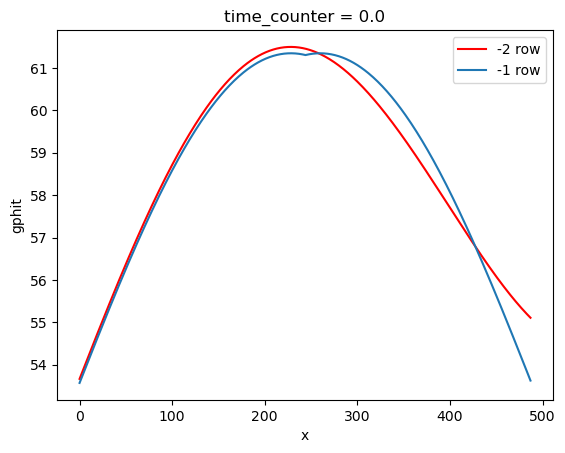

In [30]:
domain.gphit[0,-2,:].plot(c='r', label='-2 row')
domain.gphit[0,-1,:].plot(label='-1 row')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
# this = ax.pcolormesh(domain.glamt[0,:,:], domain.gphit[0,:,:], domain.bathy_metry[0,:,:],
                     # norm=divnorm, shading='gouraud',cmap=terrain_map, transform=ccrs.PlateCarree(), zorder=0)
# ax.set_extent([-180, 180, 90, 55], crs=ccrs.PlateCarree())
# ax.set_extent([70, 80, 70, 65.5], crs=ccrs.PlateCarree())
# ax.set_extent([-60, -100, 65, 50], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.RIVERS, zorder=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1)
ax.coastlines(linewidth=1, alpha=0.5, zorder=1)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=1)
fig.colorbar(this, label='Bathymetry', anchor=(0.1, 0.5))

: 

### Маска

In [26]:
# Ломаная маска
mesh_mask = xr.open_dataset('.mesh_mask_418x488.nc')

# Рабочая маска
# mesh_mask = mesh_mask.drop_isel(y=[0,-1,])
# mesh_mask['jpjglo'] = 418

mesh_mask

<xarray.Dataset>
Dimensions:       (y: 418, x: 488, nav_lev: 31, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 0.0
Dimensions without coordinates: y, x
Data variables: (12/49)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    jperio        int32 ...
    ...            ...
    e3v_0         (time_counter, nav_lev, y, x) float64 ...
    e3w_0         (time_counter, nav_lev, y, x) float64 ...
    gdept_1d      (time_counter, nav_lev) float64 ...
    gdepw_1d      (time_counter, nav_lev) float64 ...
    gdept_0       (time_counter, nav_lev, y, x) float64 ...
    gdepw_0       (time_counter, nav_lev, y, x) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  21/12/2022 09:56:50 +0000

/home/hydmet/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:531: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/hydmet/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:543: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
/home/hydmet/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/hydmet/anaconda3/lib/python3.9/site-packages

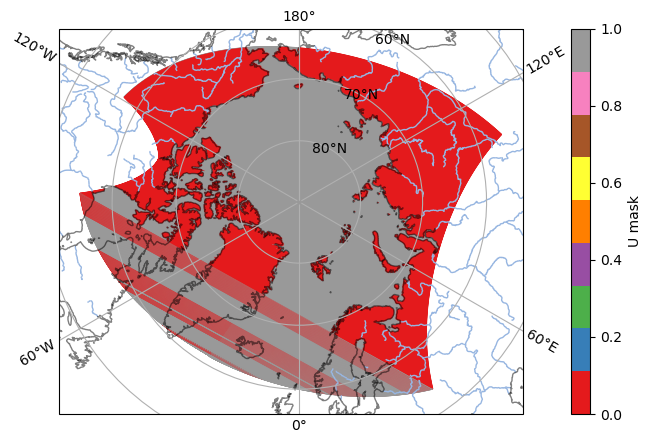

In [27]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
this = ax.pcolormesh(mesh_mask.nav_lon[:,:], mesh_mask.nav_lat[:,:],mesh_mask.umask[0,0,:,:],
                     shading='gouraud', transform=ccrs.PlateCarree(), cmap='Set1', zorder=0)
# ax.set_extent([-180, 180, 90, 55], crs=ccrs.PlateCarree())
# ax.set_extent([-60, -100, 65, 50], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.RIVERS, zorder=1)
# ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1)
ax.coastlines(linewidth=1, alpha=0.5, zorder=1)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=True, zorder=1)
fig.colorbar(this, label='U mask', anchor=(0.1, 0.5))

## Подготовка граничных данных

### Файл координат граничных условий

Пример структуры файла координат граничных условий из мануала NEMO v4.2.0 (стр. 118)\
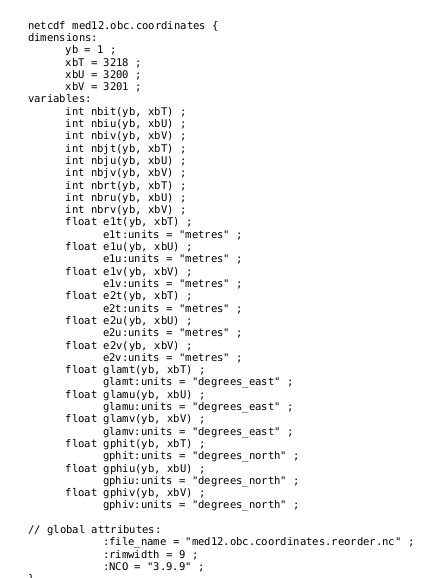

In [22]:
order = [1,-2,2,-3,3,-4]  # Порядок обращения к строкам домена
rims = [1,1,2,2,3,3]  # Расстояние от края

In [23]:
e1t_lbc = xr.concat([domain.e1t[0,row,:] for row in order],dim='x')
e1u_lbc = xr.concat([domain.e1u[0,row,:] for row in order],dim='x')
e1v_lbc = xr.concat([domain.e1v[0,row,:] for row in order],dim='x')
e2t_lbc = xr.concat([domain.e2t[0,row,:] for row in order],dim='x')
e2u_lbc = xr.concat([domain.e2u[0,row,:] for row in order],dim='x')
e2v_lbc = xr.concat([domain.e2v[0,row,:] for row in order],dim='x')
gphit_lbc = xr.concat([domain.gphit[0,row,:] for row in order],dim='x')
gphiu_lbc = xr.concat([domain.gphiu[0,row,:] for row in order],dim='x')
gphiv_lbc = xr.concat([domain.gphiv[0,row,:] for row in order],dim='x')
glamt_lbc = xr.concat([domain.glamt[0,row,:] for row in order],dim='x')
glamu_lbc = xr.concat([domain.glamu[0,row,:] for row in order],dim='x')
glamv_lbc = xr.concat([domain.glamv[0,row,:] for row in order],dim='x')
nbit = np.concatenate([np.full((488),domain.y[i]) for i in order],axis=None)
nbiu = np.concatenate([np.full((488),domain.y[i]) for i in order],axis=None)
nbiv = np.concatenate([np.full((488),domain.y[i]) for i in order],axis=None)
nbjt = xr.concat([domain.x for i in range(6)],dim='x')
nbju = xr.concat([domain.x for i in range(6)],dim='x')
nbjv = xr.concat([domain.x for i in range(6)],dim='x')
nbrt = np.concatenate([np.full((488),rim) for rim in rims],axis=None)
nbru = np.concatenate([np.full((488),rim) for rim in rims],axis=None)
nbrv = np.concatenate([np.full((488),rim) for rim in rims],axis=None)

A025_bdy_coords = xr.Dataset(
                 {
                     'nbit':('xbT',nbit.data),
                     'nbiu':('xbU',nbiu.data),
                     'nbiv':('xbV',nbiv.data),
                     'nbjt':('xbT',nbjt.data),
                     'nbju':('xbU',nbju.data),
                     'nbjv':('xbV',nbjv.data),
                     'nbrt':('xbT',nbrt.data),
                     'nbru':('xbU',nbru.data),
                     'nbrv':('xbV',nbrv.data),
                     'e1t':('xbT',e1t_lbc.data),
                     'e1u':('xbU',e1u_lbc.data),
                     'e1v':('xbV',e1v_lbc.data),
                     'e2t':('xbT',e2t_lbc.data),
                     'e2u':('xbU',e2u_lbc.data),
                     'e2v':('xbV',e2v_lbc.data),
                     'gphit':('xbT',gphit_lbc.data),
                     'gphiu':('xbU',gphiu_lbc.data),
                     'gphiv':('xbV',gphiv_lbc.data),
                     'glamt':('xbT',glamt_lbc.data),
                     'glamu':('xbU',glamu_lbc.data),
                     'glamv':('xbV',glamv_lbc.data)
                 }
                 ).reset_coords(drop=True).expand_dims('yb')

A025_bdy_coords

<xarray.Dataset>
Dimensions:  (yb: 1, xbT: 2928, xbU: 2928, xbV: 2928)
Dimensions without coordinates: yb, xbT, xbU, xbV
Data variables: (12/21)
    nbit     (yb, xbT) int64 1 1 1 1 1 1 1 1 ... 414 414 414 414 414 414 414 414
    nbiu     (yb, xbU) int64 1 1 1 1 1 1 1 1 ... 414 414 414 414 414 414 414 414
    nbiv     (yb, xbV) int64 1 1 1 1 1 1 1 1 ... 414 414 414 414 414 414 414 414
    nbjt     (yb, xbT) int64 0 1 2 3 4 5 6 7 ... 480 481 482 483 484 485 486 487
    nbju     (yb, xbU) int64 0 1 2 3 4 5 6 7 ... 480 481 482 483 484 485 486 487
    nbjv     (yb, xbV) int64 0 1 2 3 4 5 6 7 ... 480 481 482 483 484 485 486 487
    ...       ...
    gphit    (yb, xbT) float64 56.14 56.21 56.28 56.34 ... 55.34 55.32 55.29
    gphiu    (yb, xbU) float64 56.18 56.24 56.31 56.38 ... 55.35 55.33 55.3
    gphiv    (yb, xbV) float64 56.19 56.25 56.32 56.39 ... 55.38 55.36 55.34
    glamt    (yb, xbT) float64 108.4 108.6 108.8 109.0 ... -91.91 -92.13 -92.36
    glamu    (yb, xbU) float64 108.5 108.7 108.9 109.1 ... -91.8 -92.02 -92.25
    glamv    (yb, xbV) float64 108.3 108.5 108.7 109.0 ... -91.93 -92.15 -92.37

/home/hydmet/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:531: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/hydmet/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:543: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
/home/hydmet/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/hydmet/anaconda3/lib/python3.9/site-packages

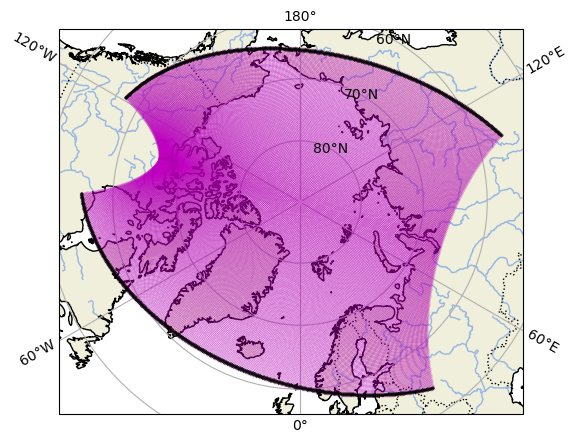

In [24]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.scatter(itogo.nav_lon[:,:], itogo.nav_lat[:,:], transform=ccrs.PlateCarree(), s=0.003, c='m', zorder=2)
ax.scatter(A025_bdy_coords.glamt[:], A025_bdy_coords.gphit[:], transform=ccrs.PlateCarree(), s=0.1, c='k', zorder=2)
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.RIVERS, zorder=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1)
ax.coastlines(linewidth=1, zorder=1)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=True, zorder=1)

### Создание файла маски граничных условий

In [25]:
tmask_lbc = xr.concat([mesh_mask.tmask[0,:,row,:] for row in order],dim='x')
umask_lbc = xr.concat([mesh_mask.umask[0,:,row,:] for row in order],dim='x')
vmask_lbc = xr.concat([mesh_mask.vmask[0,:,row,:] for row in order],dim='x')

A025_bdy_mask = xr.Dataset(
                 {
                     'tmask':(['nav_lev','xbT'],tmask_lbc.data),
                     'umask':(['nav_lev','xbU'],umask_lbc.data),
                     'vmask':(['nav_lev','xbV'],vmask_lbc.data),
                     'gphit':('xbT',gphit_lbc.data),
                     'gphiu':('xbU',gphiu_lbc.data),
                     'gphiv':('xbV',gphiv_lbc.data),
                     'glamt':('xbT',glamt_lbc.data),
                     'glamu':('xbU',glamu_lbc.data),
                     'glamv':('xbV',glamv_lbc.data)
                 }
                 ).expand_dims('yb').transpose('nav_lev',...)

A025_bdy_mask

<xarray.Dataset>
Dimensions:  (yb: 1, nav_lev: 31, xbT: 2928, xbU: 2928, xbV: 2928)
Dimensions without coordinates: yb, nav_lev, xbT, xbU, xbV
Data variables:
    tmask    (nav_lev, yb, xbT) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    umask    (nav_lev, yb, xbU) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    vmask    (nav_lev, yb, xbV) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    gphit    (yb, xbT) float64 56.14 56.21 56.28 56.34 ... 55.34 55.32 55.29
    gphiu    (yb, xbU) float64 56.18 56.24 56.31 56.38 ... 55.35 55.33 55.3
    gphiv    (yb, xbV) float64 56.19 56.25 56.32 56.39 ... 55.38 55.36 55.34
    glamt    (yb, xbT) float64 108.4 108.6 108.8 109.0 ... -91.91 -92.13 -92.36
    glamu    (yb, xbU) float64 108.5 108.7 108.9 109.1 ... -91.8 -92.02 -92.25
    glamv    (yb, xbV) float64 108.3 108.5 108.7 109.0 ... -91.93 -92.15 -92.37

### Создание файлов данных граничных условий (в работе)